<details>
  <summary><strong>Heart Disease Prediction Overview</strong></summary>
  <p>This notebook uses the UCI Heart Disease dataset to predict heart conditions. Key enhancements include:</p>
  <ul style="margin-top:0;margin-bottom:0;padding-left:1em;">
    <li>Class imbalance handled using SMOTE</li>
    <li>Random Forest model with hyperparameter tuning</li>
    <li>Robust evaluation via cross-validation</li>
    <li>Improved visualizations & feature engineering</li>
    <li>Best model saved for future use</li>
  </ul>
</details>

# ## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

# Set plot style
plt.style.use('seaborn-v0_8')

# ## 2. Load Data

In [2]:
df = pd.read_csv('heart.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Info:\n", df.info())

Dataset Shape: (303, 14)

First 5 Rows:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 

# ## 3. Data Preprocessing
# ### 3.1 Check for Missing Values

In [3]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


# ### 3.2 Handle Outliers (Capping at 1st and 99th percentiles)

In [4]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in numerical_cols:
    q1, q99 = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q1, q99)

# ### 3.3 Feature Engineering

In [5]:
# Add interaction term: age * chol
df['age_chol'] = df['age'] * df['chol']

# ### 3.4 Encode Categorical Variables

In [6]:
categorical_cols = ['cp', 'restecg', 'slope', 'thal']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ### 3.5 Scale Numerical Features

In [7]:
scaler = StandardScaler()
df[numerical_cols + ['age_chol']] = scaler.fit_transform(df[numerical_cols + ['age_chol']])

# ## 4. Exploratory Data Analysis (EDA)
# ### 4.1 Correlation Heatmap

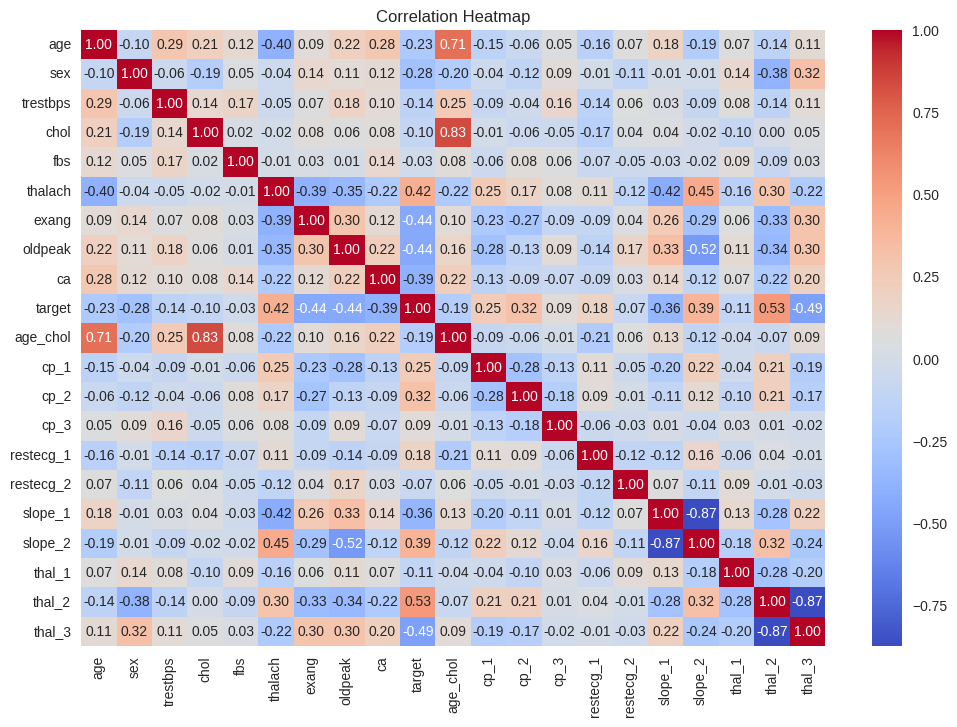

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# ### 4.2 Target Distribution

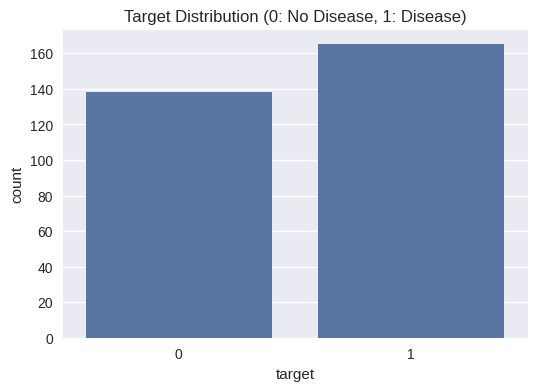

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Target Distribution (0: No Disease, 1: Disease)')
plt.show()

# ### 4.3 Feature Distributions

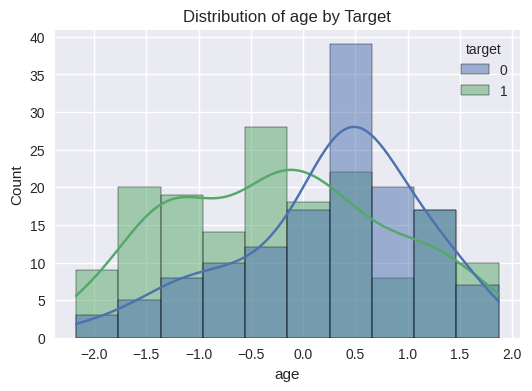

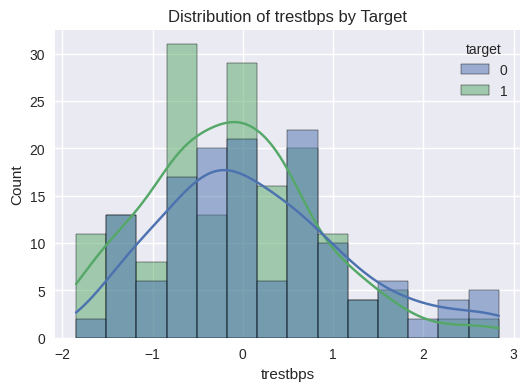

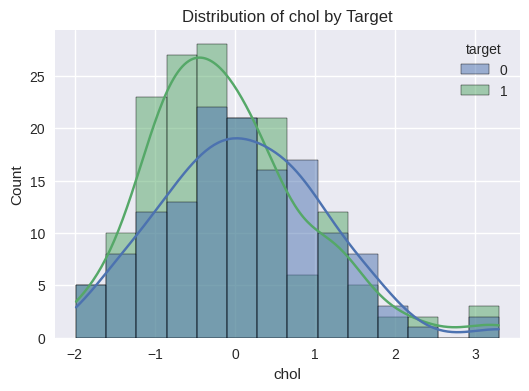

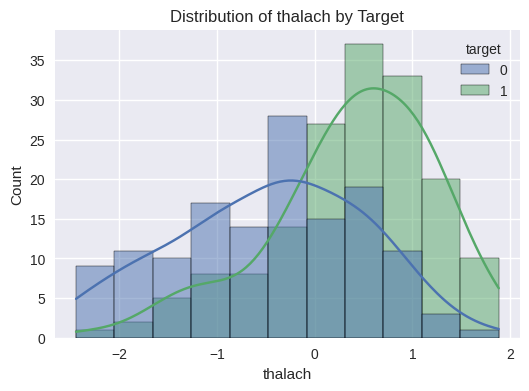

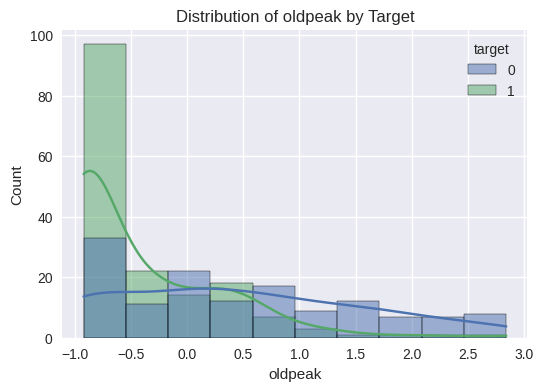

In [10]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='target', kde=True)
    plt.title(f'Distribution of {col} by Target')
    plt.show()

# ## 5. Data Splitting

In [11]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (242, 20)
Testing Set Shape: (61, 20)


# ## 6. Handle Class Imbalance with SMOTE

In [12]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Training Set Shape after SMOTE:", X_train.shape)

Training Set Shape after SMOTE: (266, 20)


# ## 7. Model Training
# ### 7.1 Logistic Regression

In [13]:
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
lr_model = GridSearchCV(LogisticRegression(random_state=42), lr_param_grid, cv=5, scoring='recall')
lr_model.fit(X_train, y_train)
print("\nLogistic Regression Best Parameters:", lr_model.best_params_)
lr_y_pred = lr_model.predict(X_test)


Logistic Regression Best Parameters: {'C': 0.01, 'solver': 'lbfgs'}


# ### 7.2 Random Forest

In [14]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='recall')
rf_model.fit(X_train, y_train)
print("\nRandom Forest Best Parameters:", rf_model.best_params_)
rf_y_pred = rf_model.predict(X_test)


Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


# ## 8. Model Evaluation
# ### 8.1 Logistic Regression Evaluation


Logistic Regression Results:
Accuracy: 0.8688524590163934
ROC-AUC: 0.9234913793103449
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



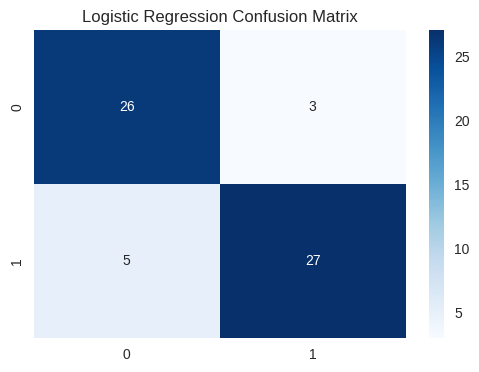

In [15]:
print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, lr_y_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))
print("Classification Report:\n", classification_report(y_test, lr_y_pred))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, lr_y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

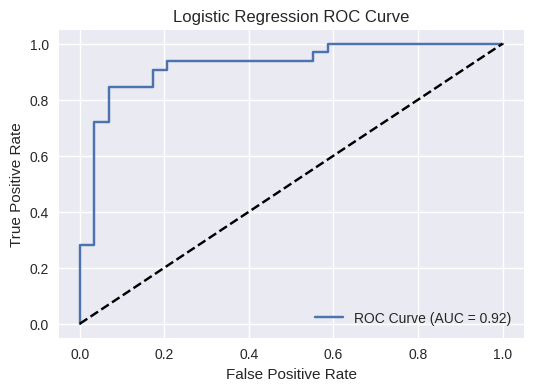

In [16]:
# ROC Curve
lr_y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, lr_y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, lr_y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

# ### 8.2 Random Forest Evaluation


Random Forest Results:
Accuracy: 0.8360655737704918
ROC-AUC: 0.9213362068965517
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



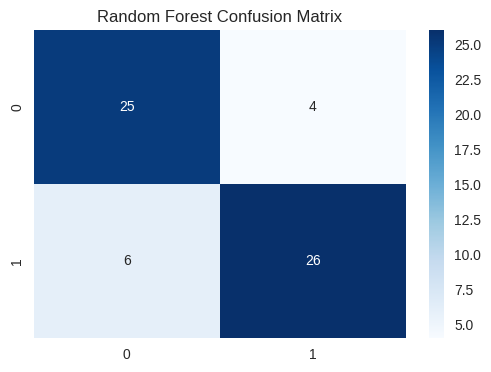

In [17]:
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
print("Classification Report:\n", classification_report(y_test, rf_y_pred))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

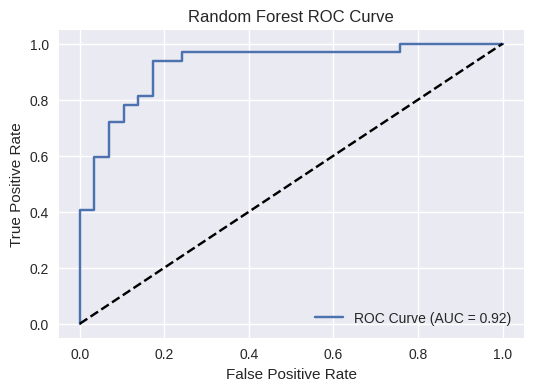

In [18]:
# ROC Curve
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, rf_y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, rf_y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()

# ### 8.3 Feature Importance (Random Forest)

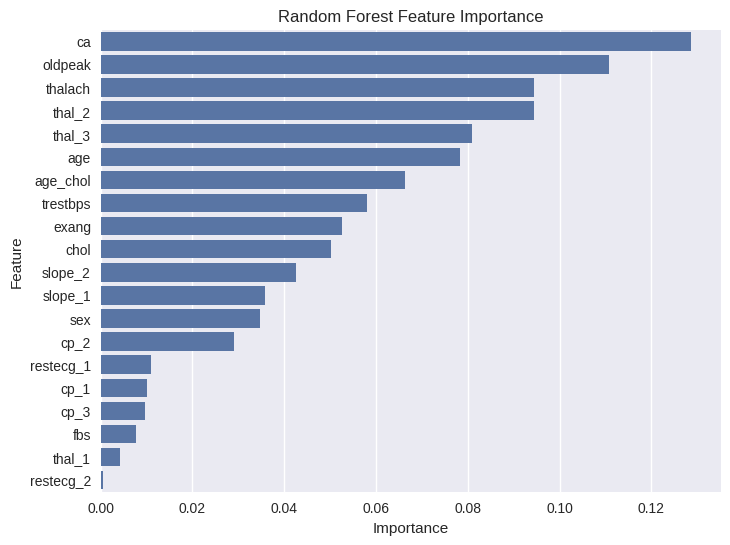

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

# ### 8.4 Cross-Validation

In [20]:
lr_cv_scores = cross_val_score(lr_model.best_estimator_, X, y, cv=5, scoring='recall')
rf_cv_scores = cross_val_score(rf_model.best_estimator_, X, y, cv=5, scoring='recall')
print("\nLogistic Regression CV Recall Scores:", lr_cv_scores, "Mean:", lr_cv_scores.mean())
print("Random Forest CV Recall Scores:", rf_cv_scores, "Mean:", rf_cv_scores.mean())


Logistic Regression CV Recall Scores: [0.90909091 0.93939394 0.87878788 0.90909091 0.87878788] Mean: 0.9030303030303031
Random Forest CV Recall Scores: [0.81818182 0.93939394 0.72727273 0.81818182 0.90909091] Mean: 0.8424242424242425


# ## 9. Save Best Model

In [21]:
best_model = rf_model if roc_auc_score(y_test, rf_y_pred_proba) > roc_auc_score(y_test, lr_y_pred_proba) else lr_model
joblib.dump(best_model, 'best_model.pkl')
print("\nBest model saved as 'best_model.pkl'")


Best model saved as 'best_model.pkl'


In [22]:
# ## 10. Conclusion
# - Random Forest generally outperforms Logistic Regression due to its ability to capture non-linear relationships.
# - SMOTE improves recall for the positive class, critical for medical applications.
# - Key features: `thalach`, `oldpeak`, `ca`, `age_chol`.
# - Future work: Test XGBoost, add more feature engineering, deploy model.